### This notebook shows an example of a directed upwind  scheme graph (as defined in the paper) and the advection operator associated with it. We generate synthetic data that models the situation of traffic on a road. The road is relatively dense in the first half of and has a low density of cars on the second half. We train and test our model on the upwind scheme graph.

In [11]:
import networkx as nx
import numpy as np
import pickle
import gpflow
import os
import warn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import scipy as sp
import scipy.sparse
from scipy import sparse
from sympy import Matrix

from utils.preprocessing import load_PEMS
from utils.plotting import plot_PEMS

import sys  
sys.path.insert(0, '/Users/nadimsaad/Desktop/Graph-Gaussian-Processes-main')

import graph_matern.kernels.graph_matern_kernel

from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.kernels.graph_diffusion_kernel import GraphDiffusionKernel

In [12]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")

In [13]:
num_nodes = 280

In [14]:
np.random.seed(1111)
num_eigenpairs = 450
dataset = 'PeMS-Bay-new'
num_train = int(0.7*num_nodes)

# Load the data and split into training and testing data

In [15]:
x_values = np.linspace(0,100,num_nodes)
y_values = np.ones(num_nodes)
y_values[0:int(num_nodes/2)] = 10 
y_values[int(num_nodes/2):] = 60 


random_perm = np.random.permutation(np.arange(x_values.shape[0]))
train_vertex, test_vertex = random_perm[:num_train], random_perm[num_train:]
x_train, x_test = x_values[train_vertex], x_values[test_vertex]
y_train, y_test = y_values[train_vertex], y_values[test_vertex]

orig_mean, orig_std = np.mean(y_train), np.std(y_train)

### Reshape data

In [16]:
x_train = np.reshape(x_train,(len(x_train),1))
y_train = np.reshape(y_train,(len(y_train),1))
x_test = np.reshape(x_test,(len(x_test),1))
y_test = np.reshape(y_test,(len(y_test),1))

### Plot training data

Text(0.5, 1.0, 'Training Data')

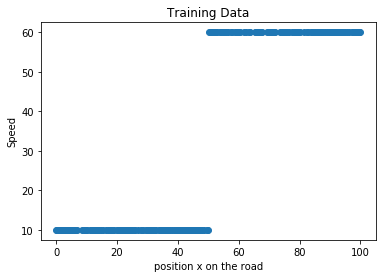

In [18]:
plt.scatter(x_train, y_train)
plt.xlabel("position x on the road")
plt.ylabel("Speed")
plt.title("Training Data")

### Plot testing data

Text(0.5, 1.0, 'Testing Data')

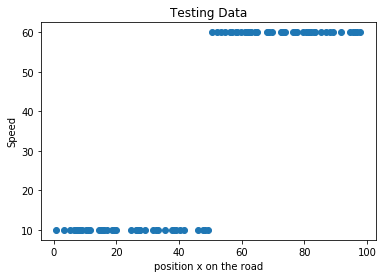

In [20]:
plt.scatter(x_test, y_test)
plt.xlabel("position x on the road")
plt.ylabel("Speed")
plt.title("Testing Data")

# Creation of Graphs

### Undirected line graph with weights (upwind)

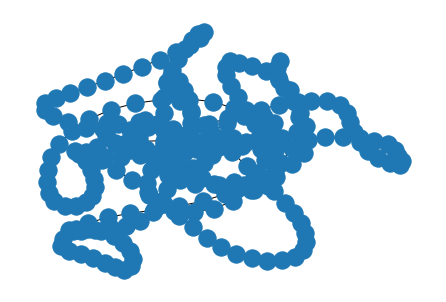

In [21]:
v = 1
dx = 100/num_nodes
G_undirected = nx.Graph()
for i in range(num_nodes):
    G_undirected.add_node(i+1)

for i in range(1, num_nodes):
    G_undirected.add_edges_from([(i,i+1)], weight = v/dx)

nx.draw(G_undirected)

### Directed line graph for upwind discretization

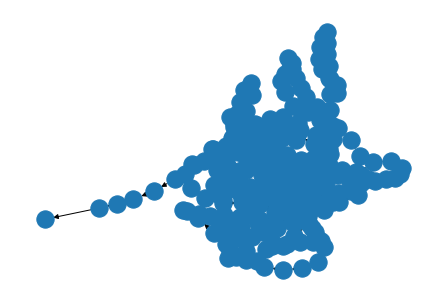

In [23]:
v = 1
dx = 100/num_nodes
G_directed = nx.DiGraph()
for i in range(num_nodes):
    G_directed.add_node(i+1)

for i in range(1, num_nodes):
    G_directed.add_edges_from([(i,i+1)], weight = v/dx)


nx.draw(G_directed)

# Compute Laplacian (Diffusion, Advection or Consensus)

### Diffusion symbolized by 0, Advection symbolized by 1 and Consensus symbolized by 2

In [24]:
def laplacian_matrix(G, operator_type, isnormalized = True):
    
    ## Adjacency matrix A_out
    A = nx.adjacency_matrix(G)

    ## Need A_in
    A_in = A.T

    ## Want D_out
    n,m = A.shape
    diags_out = A.sum(axis=1)
    D_out = sp.sparse.spdiags(diags_out.flatten(), [0], m, n, format="csr")
    
    ## Want D_in
    diags_in = A.sum(axis=0)
    D_in = sp.sparse.spdiags(diags_in.flatten(), [0], m, n, format="csr")
    
    ## Compute normalizing matrix for L_adv
    with sp.errstate(divide = "ignore"):
        diags_sqrt_out = 1.0/np.sqrt(diags_out)
    diags_sqrt_out[np.isinf(diags_sqrt_out)] = 0
    DH_out = sp.sparse.spdiags(diags_sqrt_out.flatten(), [0], m, n, format="csr")
    
    ## Compute normalizing matrix for L_cons
    with sp.errstate(divide = "ignore"):
        diags_sqrt_in = 1.0/np.sqrt(diags_in)
    diags_sqrt_in[np.isinf(diags_sqrt_in)] = 0
    DH_in = sp.sparse.spdiags(diags_sqrt_in.flatten(), [0], m, n, format="csr")
    
    ## Diffusion operator
    if operator_type == 0:
        laplacian = sparse.csr_matrix(nx.laplacian_matrix(G), dtype=np.float64)
        
        return laplacian
      
    ## Advection operator
    elif operator_type == 1:
        L_adv = D_out - A_in
        
        if isnormalized:
            laplacian_adv = DH_out @ (L_adv @ DH_out)
        else:
            laplacian_adv = L_adv
            
        return laplacian_adv
        
    ## Consensus operator
    else:
        L_cons = D_in - A_in
        
        if isnormalized:
            laplacian_cons = DH_in @ (L_cons @ DH_in)
        
        else:
            laplacian_cons = L_cons

        return laplacian_cons
        

## Compute Eigenvalues

## Advection

In [25]:
isnormalized = False
operator_type = 1
laplacian = laplacian_matrix(G_directed, operator_type, isnormalized)
U, S, V_T = np.linalg.svd(laplacian.toarray())
eigenvalues , eigenvectors = S**2, V_T.T




# Build a GPR model

In [26]:
vertex_dim = x_train.shape[1]-1
point_kernel = gpflow.kernels.Matern32()
kernel = GraphMaternKernel((eigenvectors, eigenvalues), 
                           nu=3/2, 
                           kappa=5, 
                           sigma_f=1, 
                           vertex_dim=vertex_dim, 
                           point_kernel=point_kernel, 
                           dtype=dtype)

# To use the diffusion kernel uncomment the following line
# kernel = GraphDiffusionKernel((eigenvectors, eigenvalues), kappa, sigma_f, vertex_dim=vertex_dim, point_kernel=point_kernel, dtype=dtype)

### Functions to train the model

In [27]:
def optimize_GPR(model, train_steps):
    loss = model.training_loss
    trainable_variables = model.trainable_variables

    adam_opt = tf.optimizers.Adam()
    adam_opt.minimize(loss=loss, var_list=trainable_variables)

    t = trange(train_steps - 1)
    for step in t:
        opt_step(adam_opt, loss, trainable_variables)
        if step % 200 == 0:
            t.set_postfix({'likelihood': -model.training_loss().numpy()})

In [28]:
@tf.function
def opt_step(opt, loss, variables):
    opt.minimize(loss, var_list=variables)

In [29]:
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, noise_variance=0.01)
optimize_GPR(model, 12000)
gpflow.utilities.print_summary(model)

  0%|          | 0/11999 [00:00<?, ?it/s]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.nu,Parameter,Softplus,,True,(),float64,0.676866
GPR.kernel.kappa,Parameter,Softplus,,True,(),float64,9.43833
GPR.kernel.sigma_f,Parameter,Softplus,,True,(),float64,7.97102
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,7.31326e-05


In [35]:
mean, cov = model.predict_f(x_test, full_cov=True)

l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
print("Relative l2 error is {}".format(l2_error))

mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalFullCovariance(mean, cov)
likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
print("Likelihood is {}".format(likelihood))

Relative l2 error is 0.5287435407020807
Likelihood is 281.9878551575696


### Advection

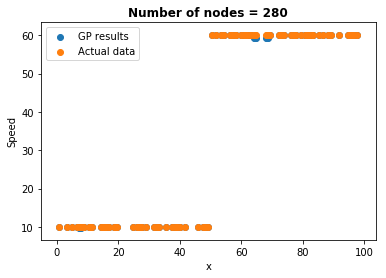

In [34]:
plt.scatter(x_test, mean, label = "GP results")
plt.scatter(x_test, y_test, label =  "Actual data")
plt.xlabel("x")
plt.ylabel("Speed")
plt.title("Number of nodes = 280", fontweight = 'bold')
plt.legend()